In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats import RectifiedLogistic
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(20)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

""" Load """
dir_name = "physio"
subdir_pattern = ["*J_RCML_000*"]
dir = os.path.join(data.data_path, dir_name)

participants = range(1, 9)

df, mat, time = load_data(dir=dir, subdir_pattern=subdir_pattern, participants=participants)


""" Custom filter """
conditions = ["C5M-C5L", "C6M-C6L", "C7M-C7L", "C8M-C8L"]

idx = df.compound_position.isin(conditions)

df = df[idx].copy()
df.reset_index(drop=True, inplace=True)

mat = mat[idx, :, :]

""" Preprocess """
df, encoder_dict, mat = data.build(df=df, mat=mat)

2023-06-23 09:40:03,608 - hb_mep.utils.utils - INFO - func:load_data took: 1.46 sec
2023-06-23 09:40:03,645 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-23 09:40:03,674 - hb_mep.utils.utils - INFO - func:preprocess took: 0.03 sec
2023-06-23 09:40:03,675 - hb_mep.utils.utils - INFO - func:build took: 0.03 sec


#### Plot

In [5]:
# plot(df=df, encoder_dict=encoder_dict, mat=mat, time=time);

#### Initialize model

In [6]:
model = RectifiedLogistic(config)

2023-06-23 09:40:03,719 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-23 09:40:03,720 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2023-06-23 09:40:03,720 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-23 09:40:03,721 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-23 09:40:03,722 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

2023-06-23 10:01:03,197 - hb_mep.utils.utils - INFO - func:run_inference took: 20 min and 59.41 sec


#### Diagnostics

In [8]:
mcmc.print_summary(prob=.95)


                               mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0,0]    199.95      0.77    199.95    198.42    201.55   6655.60      1.00
                 a[0,1,0]     55.60      1.90     55.48     52.50     59.97   3686.64      1.00
                 a[0,2,0]    246.52     84.89    257.87     55.41    390.42   6815.61      1.00
                 a[0,3,0]     20.81      2.69     21.12     16.20     25.55    791.93      1.00
                 a[0,4,0]     31.75      1.72     31.45     28.96     35.42   3693.46      1.00
                 a[0,5,0]     14.81      4.00     15.22      6.42     22.10   8047.57      1.00
                 a[0,6,0]     59.23      1.05     59.21     57.18     61.60   8561.22      1.00
                 a[0,7,0]     29.88      5.36     30.74     17.43     38.83   1295.65      1.00
                 a[1,0,0]    212.15     72.78    215.08     45.79    348.54   3344.08      1.00
                 a[1,1,0]    179.48    

#### Plot fitted curves

2023-06-22 16:53:09,469 - hb_mep.utils.utils - INFO - func:plot took: 15 min and 8.75 sec


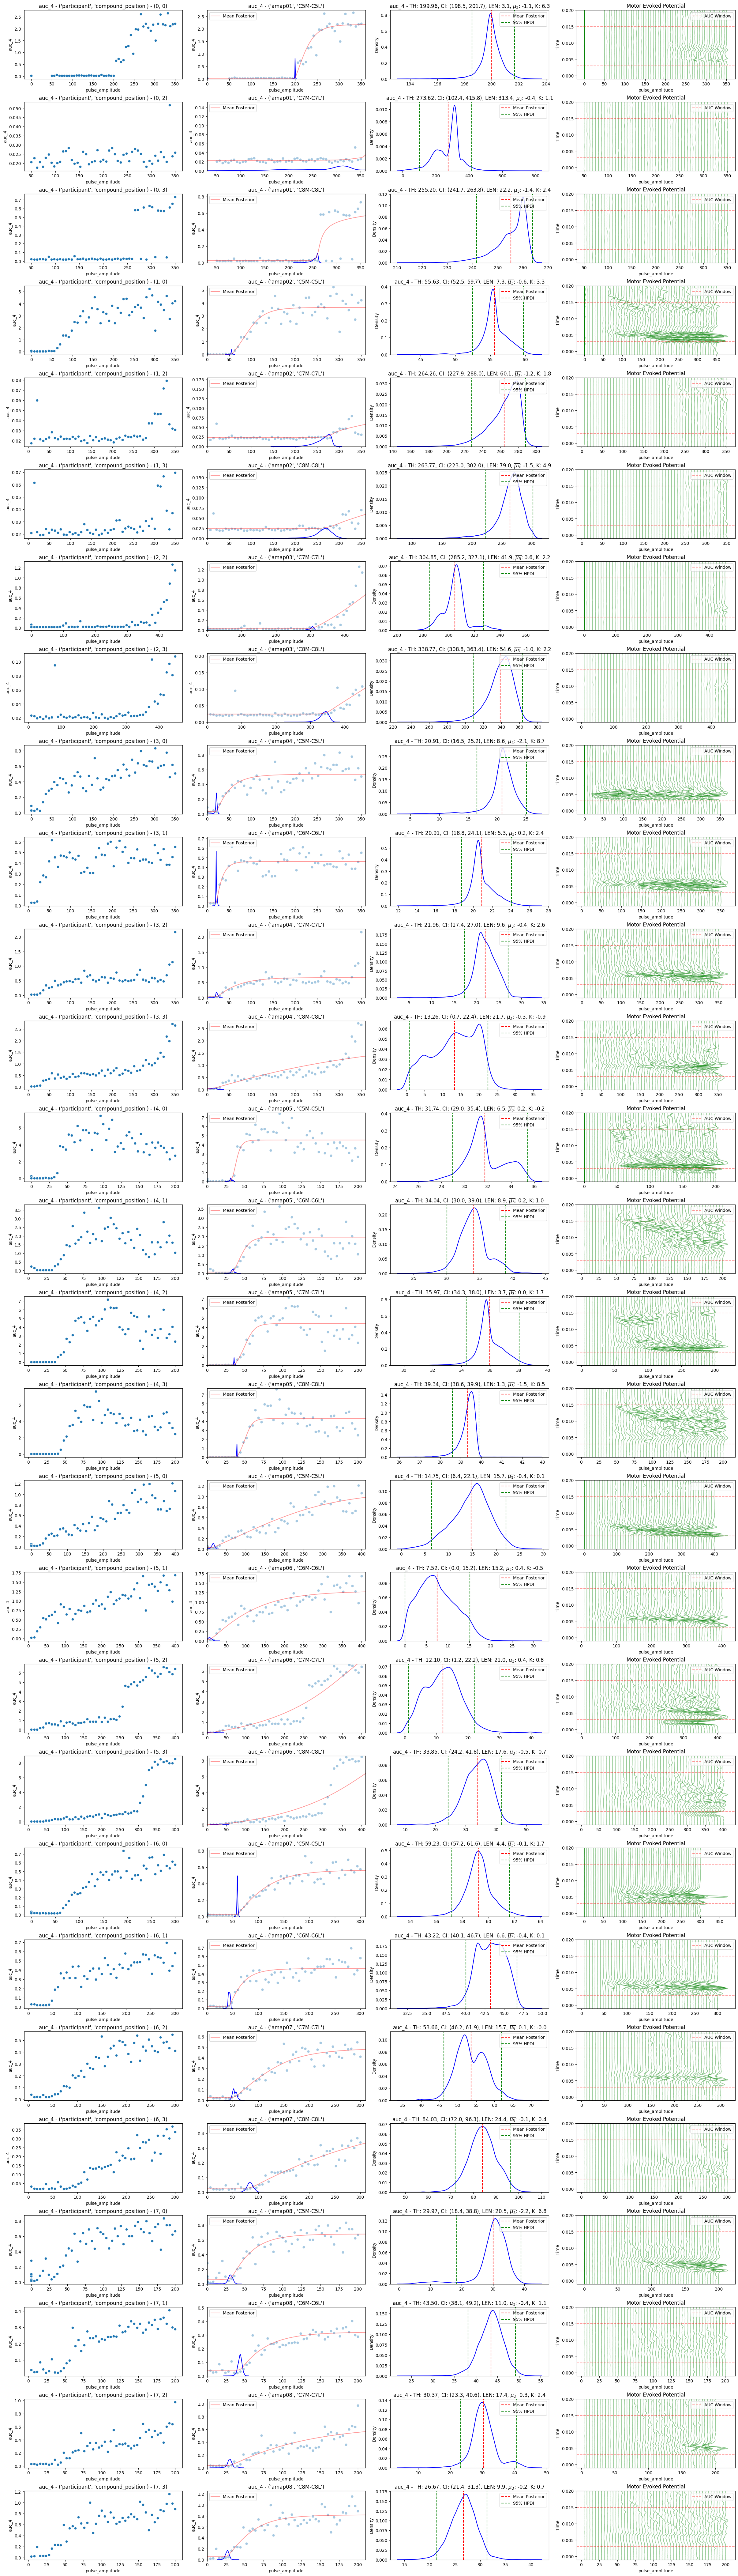

In [ ]:
model.plot(df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict, mat=mat, time=time);

2023-06-22 17:22:14,801 - hb_mep.utils.utils - INFO - func:predictive_check took: 27 min and 45.51 sec


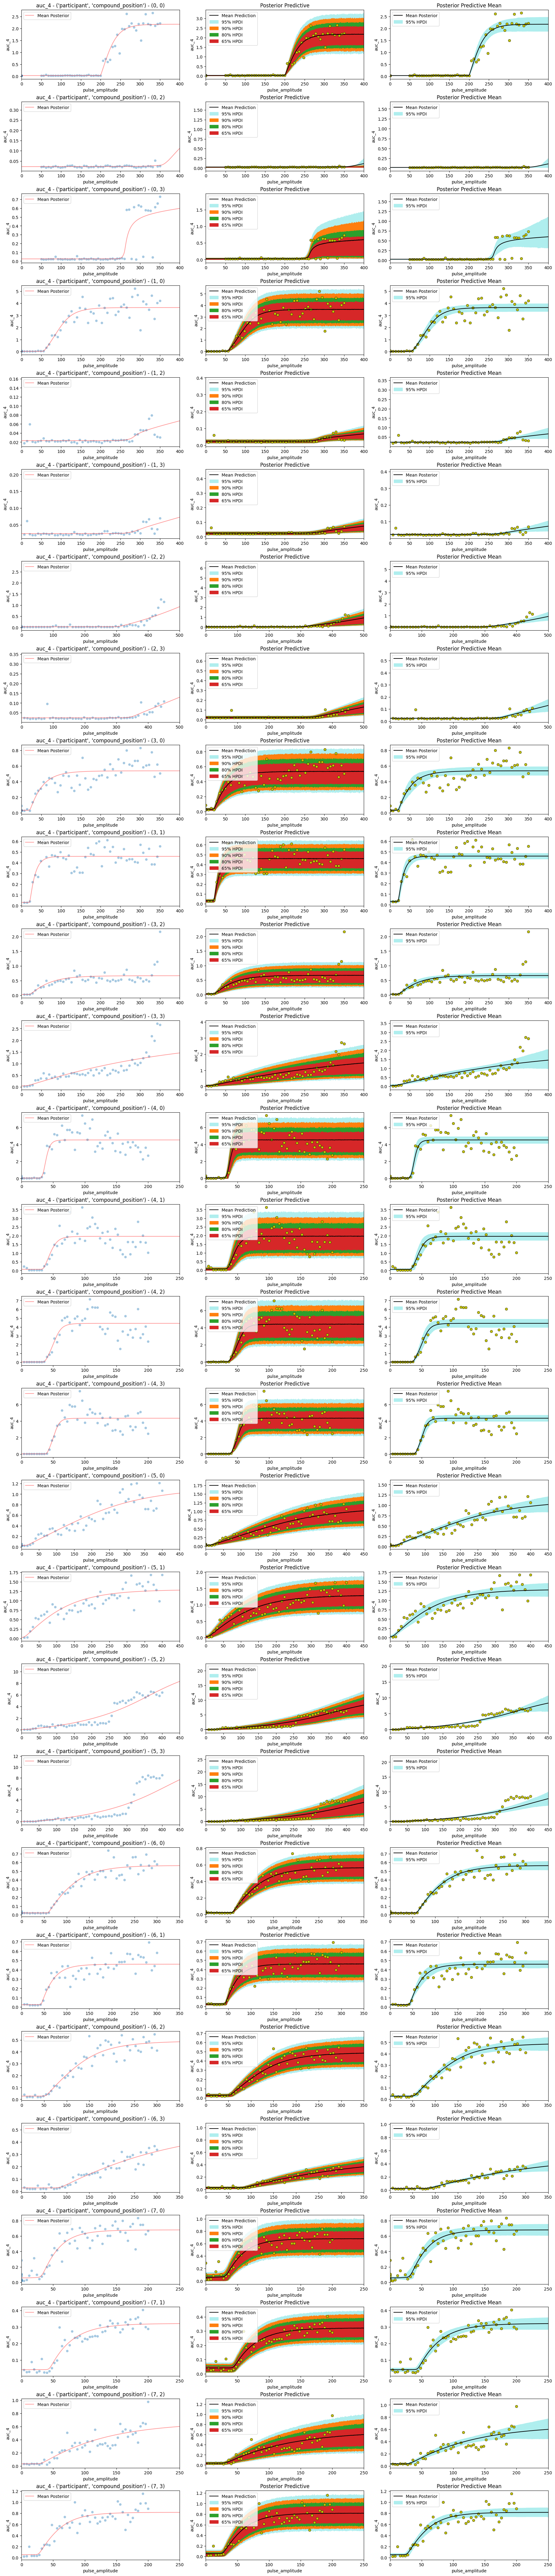

In [ ]:
model.predictive_check(df=df, posterior_samples=posterior_samples);